In [1]:
# Importamos las librerías necesarias
import pandas as pd # type: ignore
import numpy as np # type: ignore
import psycopg2 as ps # type: ignore
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Creamos la conexión a la base de datos
# Vamos a crear una conexión a la base de datos.
conn = ps.connect(
    dbname = "BBDD_Hoteles", # base a la que nos queremos conectar
    user = "postgres",
    password = "admin",
    host = "localhost",
    port = "5432" # puerto en el que s eencuentra postgres
)

In [3]:
# Creamos un cursor el cual nos va a permitir ejecutar querys.
cur = conn.cursor()

In [4]:
# COmprobamos que la conexión está creada y conectada
cur.execute("SELECT version();")
cur.fetchone() 

('PostgreSQL 16.4, compiled by Visual C++ build 1940, 64-bit',)

## Bonus Track 2

## Consulta 1: Cuantos hoteles tiene la base de datos


In [13]:
query1 = """
    SELECT 
        count(id_hotel) 
    FROM hoteles; 
"""
cur.execute(query1)
q1 = cur.fetchall()
print(f"La base de datos tiene {q1[0][0]} hoteles")

La base de datos tiene 29 hoteles


## Consulta 2: Cuantas reservas se han hecho

In [15]:
query2 = """
    SELECT 
        count(id_reserva) 
    FROM reservas; 
"""
cur.execute(query2)
q2 = cur.fetchall()
print(f"Se han realizado un total de {q2[0][0]} reservas")

Se han realizado un total de 15000 reservas


## Consulta 3: Identifica los 10 clientes que más se han gastado


In [29]:
query3 = """
    SELECT 
        c.nombre,
        sum(r.precio_noche)
    FROM clientes as c
        INNER JOIN  reservas as r ON c.id_cliente = r.id_cliente
    GROUP BY c.nombre
    ORDER BY 2 DESC
    LIMIT 10; 
"""
cur.execute(query3)
q3 = cur.fetchall()
q3[1][0]
print(f"Los clientes que más se han gastado son: {q3[0][0]} con  {q3[0][1]}€, {q3[1][0]} con  {q3[1][1]}€, {q3[1][0]} con  {q3[0][1]}€, {q3[3][0]} con  {q3[0][1]}€, {q3[4][0]} con  {q3[5][0]}€, {q3[0][0]} con  {q3[0][1]}€, {q3[0][0]} con  {q3[0][1]}€, {q3[0][0]} con  {q3[0][1]}€, {q3[0][0]} con  {q3[0][1]}€, {q3[0][0]} con  {q3[0][1]}€, {q3[0][0]} con  {q3[0][1]}€. ")

Los clientes que más se han gastado son: Nazaret con  9194.233058437145€, Reyes con  8830.594966228322€, Reyes con  9194.233058437145€, Amor con  9194.233058437145€, Trinidad con  Cruz€, Nazaret con  9194.233058437145€, Nazaret con  9194.233058437145€, Nazaret con  9194.233058437145€, Nazaret con  9194.233058437145€, Nazaret con  9194.233058437145€, Nazaret con  9194.233058437145€. 


## Consulta 4: Identifica el hotel de la competencia y el hotel de nuestra marca que más han recaudado para esas fechas


In [31]:
# Hotel competencia con mas recaudacion
query4 = """ 
        SELECT 
            h.nombre_hotel,
            sum(r.precio_noche)
        FROM hoteles as h
            INNER JOIN  reservas as r ON h.id_hotel = r.id_hotel
        WHERE h.competencia = True
        GROUP BY h.nombre_hotel
        ORDER BY 2 DESC
        LIMIT 1; 
"""

cur.execute(query4)
q4 = cur.fetchall()
print(f"El hotel de la competencia que más ha recaudado ha sido {q4[0][0]}, con un total de {q4[0][1]}€.")

El hotel de la competencia que más ha recaudado ha sido ibis Madrid Centro las Ventas, con un total de 90128.0€.


In [32]:
# Hotel grupo con mas recaudacion
query4_1 = """ 
        SELECT 
            h.nombre_hotel,
            sum(r.precio_noche)
        FROM hoteles as h
            INNER JOIN  reservas as r ON h.id_hotel = r.id_hotel
        WHERE h.competencia = False
        GROUP BY h.nombre_hotel
        ORDER BY 2 DESC
        LIMIT 1; 
"""

cur.execute(query4_1)
q5 =cur.fetchall()
print(f"El hotel del grupo que más ha recaudado ha sido {q5[0][0]}, con un total de {q5[0][1]}€.")

El hotel del grupo que más ha recaudado ha sido Hotel Monte Verde, con un total de 152136.8095238094€.


## Consulta 5: Identifica cuantos eventos hay.


In [33]:
# Hotel competencia con mas recaudacion
query5 = """ 
        SELECT 
            count(id_evento)
        FROM eventos ; 
"""

cur.execute(query5)
q6 = cur.fetchall()
print(f"Hay un total de {q6[0][0]} eventos.")

Hay un total de 217 eventos.


## Consulta 6: Identifica el día que más reservas se han hecho para nuestro hoteles

In [39]:
# Hotel competencia con mas recaudacion
query6 = """ 
        SELECT 
            r.fecha_reserva,
            count(r.id_reserva)
        FROM hoteles as h
            INNER JOIN  reservas as r ON h.id_hotel = r.id_hotel
        WHERE h.competencia = True
        GROUP BY r.fecha_reserva ; 
"""

cur.execute(query6)
q7 = cur.fetchall()
print(f"El dia que mas reservas se han realizado ha sido el {q7[0][0]} con un total de {q7[0][1]} reservas.")


El dia que mas reservas se han realizado ha sido el 2025-02-21 con un total de 5172 reservas.


In [48]:
# una vez hemos terminado de trabajar es necesario cerrar la conexión y el cursor.
cur.close()
conn.close()

## Bonus Track 2
Una vez creada la base de datos haz una o varias consultas para crear un dataframe con los datos relevantes para hacer un análisis de precios entre la competencia y nuestros hoteles para esas fechas. Realiza un análisis temporal de las fechas de reserva

### Hoteles del grupo

Vamos a analizar lo siguiente:
- recaudacion mensual
- numero de reservas mensuales
- nº de clientes que han realziado reservas
- Big numbers: precio medio de noche de los hoteles, nº reservas al año, recaudacion anual total, valoracion media de los hoteles del grupo, nº hoteles del grupo

In [5]:
# df hoteles grupo 
query7 = """ 
        CREATE VIEW "Vista_hoteles_grupo" AS
        SELECT 
            h.id_hotel ,
            h.nombre_hotel,
            h.valoracion,
            r.id_reserva,
            r.fecha_reserva,
            r.precio_noche,
            c.id_cliente,
            concat(c."nombre", ' ', c."apellido")
        FROM hoteles as h
            INNER JOIN  reservas AS r ON h.id_hotel = r.id_hotel
            INNER JOIN  clientes AS c ON r.id_cliente = c.id_cliente
        WHERE h.competencia = False; 
"""

cur.execute(query7)
conn.commit()


#### Big numbers

In [39]:
# Recaudacion total anual
query_rec_grupo = """ 
        SELECT 
                SUM(precio_noche)
        FROM "Vista_hoteles_grupo"; 
"""

cur.execute(query_rec_grupo)
rec_total = cur.fetchall()
round(rec_total[0][0], 2)


2703317.14

In [38]:
# Precio medio noche
query_p_medio = """ 
        SELECT AVG(precio_noche)
        FROM "Vista_hoteles_grupo"; 
"""

cur.execute(query_p_medio)
p_medio = cur.fetchall()
round(p_medio[0][0], 2)

275.06

In [27]:
# Nº de reservas totales
query_n_reservas = """ 
        SELECT count(id_reserva)
        FROM "Vista_hoteles_grupo"; 
"""

cur.execute(query_n_reservas)
reservas_tot = cur.fetchall()
reservas_tot[0][0]

9828

In [41]:
# Valoracion media
query_v_media = """ 
        SELECT AVG(valoracion)
        FROM "Vista_hoteles_grupo"; 
"""

cur.execute(query_v_media)
v_media = cur.fetchall()
round(v_media[0][0], 2)

3.01

#### Análisis por hotel

In [8]:
# Vamos a analizar los ingresos por hotel, y el numero de reservas por hotel
query7_1 = """ 

        SELECT 
                nombre_hotel,
                sum(precio_noche),
                count(id_reserva)
        FROM "Vista_hoteles_grupo"
        GROUP BY nombre_hotel
        ORDER BY 2 DESC; 
"""

cur.execute(query7_1)
q7_1 = cur.fetchall()
df_grupo = pd.DataFrame(q7_1)
df_grupo

,0,1,2
0,Hotel Monte Verde,152136.809524,550
1,Hotel Sol y Luna,149237.766793,557
2,Hotel Puerta del Cielo,147359.553728,526
3,Hotel Brisas del Mar,146970.641842,534
4,Hotel Costa Azul,146405.725926,515
5,Hotel Los Almendros,145915.665951,533
6,Hotel Mirador Real,145661.051096,533
7,Hotel Luz de Madrid,144685.485607,536
8,Palacio del Sol,144070.996450,510
9,Hotel Vista Alegre,142978.894283,511


Vamos a realizar un análisis temporal

C:\Users\gabri\AppData\Local\Temp\ipykernel_25944\1495420374.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels = df_grupo[0], rotation=45, ha='right')
C:\Users\gabri\AppData\Local\Temp\ipykernel_25944\1495420374.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels = df_grupo[0], rotation=45, ha='right')


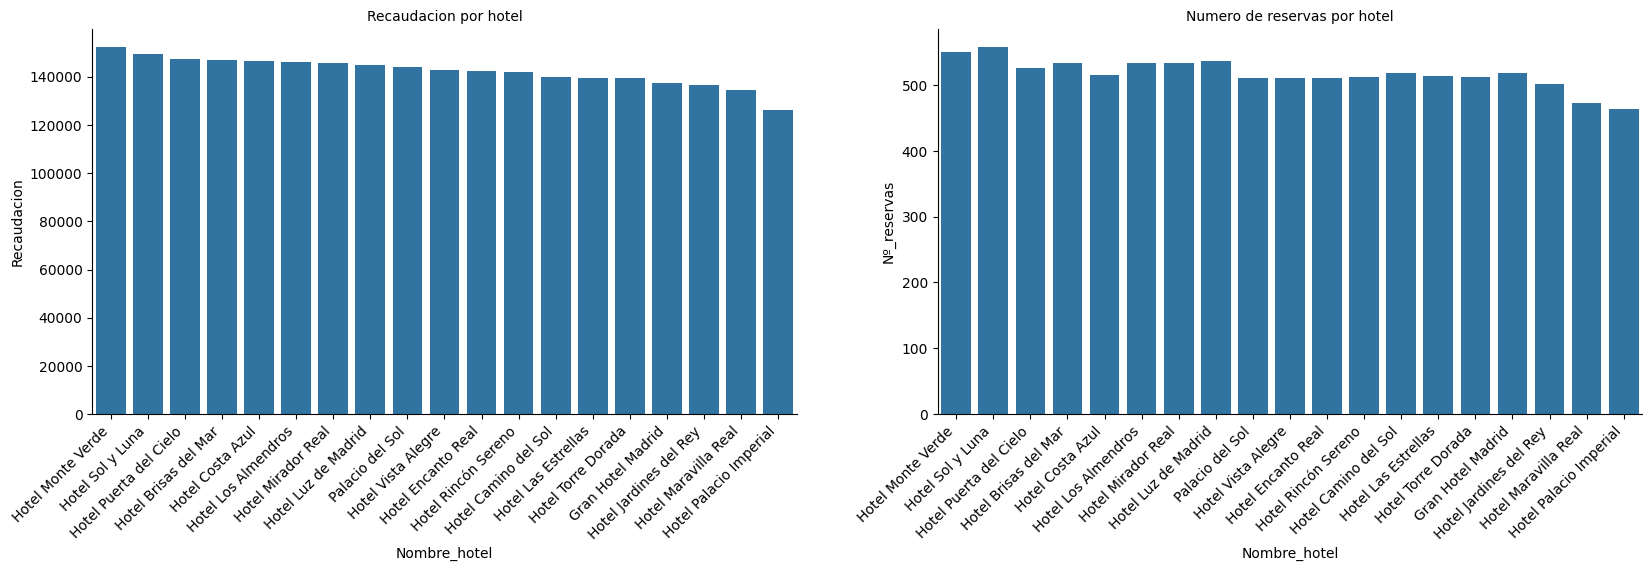

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x = 0, 
            y = 1,
            data = df_grupo,
            ax = axes[0])
sns.barplot(x = 0, 
            y = 2,
            data = df_grupo, 
            ax = axes[1])

axes[0].set_title(f"Recaudacion por hotel", fontsize = 10)
axes[0].set_xlabel("Nombre_hotel", fontsize = 10)
axes[0].set_ylabel("Recaudacion", fontsize = 10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_xticklabels(labels = df_grupo[0], rotation=45, ha='right')


axes[1].set_title(f"Numero de reservas por hotel", fontsize = 10)
axes[1].set_ylabel("Nº_reservas", fontsize = 10)
axes[1].set_xlabel("Nombre_hotel", fontsize = 10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xticklabels(labels = df_grupo[0], rotation=45, ha='right')

plt.show()


#### Análisis temporal

In [16]:
query7_2 = """ 

        SELECT 
                fecha_reserva,
                sum(precio_noche),
                count(id_reserva)
        FROM "Vista_hoteles_grupo"
        GROUP BY fecha_reserva
        ORDER BY 2 DESC; 
"""

cur.execute(query7_2)
q7_2 = cur.fetchall()
df_grupo_2 = pd.DataFrame(q7_2)
df_grupo_2

,0,1,2
0,2025-02-06,239721.551827,872
1,2025-02-04,239433.396627,871
2,2025-02-02,234535.354832,853
3,2025-02-03,229188.665161,833
4,2025-02-05,227062.065530,825
5,2025-02-09,225749.555078,820
6,2025-02-01,223628.190659,814
7,2025-02-10,223556.297471,812
8,2025-02-12,223145.408956,811
9,2025-02-11,213244.128054,775


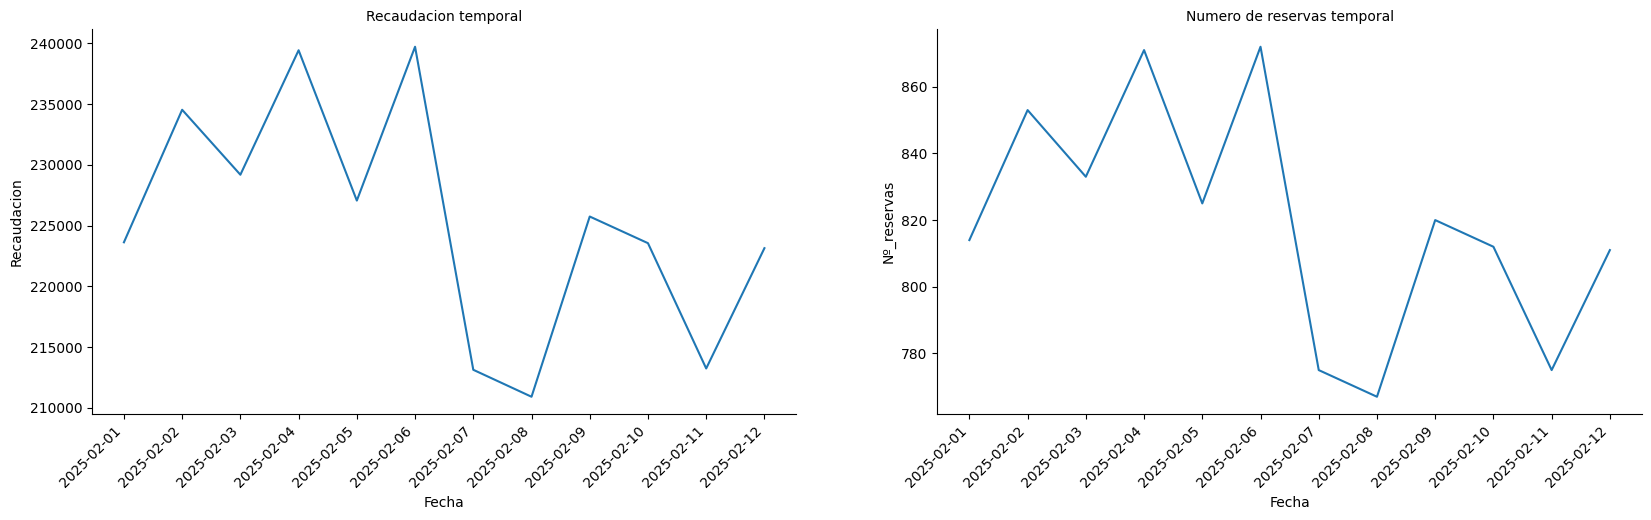

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.lineplot(x = 0,
              y = 1,
              data = df_grupo_2,
              ax = axes[0])

sns.lineplot(x = 0,
              y = 2,
              data = df_grupo_2,
              ax = axes[1])

axes[0].set_title(f"Recaudacion temporal", fontsize = 10)
axes[0].set_xlabel("Fecha", fontsize = 10)
axes[0].set_ylabel("Recaudacion", fontsize = 10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_xticks(df_grupo_2[0])
axes[0].set_xticklabels(df_grupo_2[0], rotation=45, ha='right')

axes[1].set_title(f"Numero de reservas temporal", fontsize = 10)
axes[1].set_ylabel("Nº_reservas", fontsize = 10)
axes[1].set_xticks(df_grupo_2[0])
axes[1].set_xticklabels(df_grupo_2[0], rotation=45, ha='right')
axes[1].set_xlabel("Fecha", fontsize = 10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

plt.show()

### Hoteles de la competencia
Vamos a analizar lo siguiente:
- recaudacion mensual
- numero de reservas mensuales
- nº de clientes que han realziado reservas
- Big numbers: precio medio de noche de los hoteles, nº reservas al año, recaudacion anual total, valoracion media de los hoteles del grupo, nº hoteles del grupo

In [42]:
# df hoteles competencia 
query8 = """ 
        CREATE VIEW "Vista_hoteles_competencia" AS
        SELECT 
            h.id_hotel ,
            h.nombre_hotel,
            h.valoracion,
            r.id_reserva,
            r.fecha_reserva,
            r.precio_noche,
            c.id_cliente,
            concat(c."nombre", ' ', c."apellido")
        FROM hoteles as h
            INNER JOIN  reservas as r ON h.id_hotel = r.id_hotel
            INNER JOIN  clientes AS c ON r.id_cliente = c.id_cliente
        WHERE h.competencia = True; 
"""

cur.execute(query8)
conn.commit()


#### Big numbers

In [43]:
# Recaudacion total anual
query_rec_comp = """ 
        SELECT 
                SUM(precio_noche)
        FROM "Vista_hoteles_competencia"; 
"""

cur.execute(query_rec_comp)
rec_total_c = cur.fetchall()
round(rec_total_c[0][0], 2)


580029.0

In [44]:
# Precio medio noche
query_p_medio_c = """ 
        SELECT AVG(precio_noche)
        FROM "Vista_hoteles_competencia"; 
"""

cur.execute(query_p_medio_c)
p_medio_c = cur.fetchall()
round(p_medio_c[0][0], 2)

112.15

In [51]:
# Nº de reservas totales
query_n_reservas_c = """ 
        SELECT count(id_reserva)
        FROM "Vista_hoteles_competencia"; 
"""

cur.execute(query_n_reservas)
reservas_tot_c = cur.fetchall()
reservas_tot_c[0][0]

9828

In [55]:
# Valoracion media
query_v_media_c = """ 
        SELECT AVG(valoracion)
        FROM "Vista_hoteles_competencia"; 
"""

cur.execute(query_v_media_c)
v_media_c = cur.fetchall()
round(v_media_c[0][0], 2)

4.39

#### Análisis por hotel

In [46]:
query8_1 = """ 
        SELECT 
                nombre_hotel,
                sum(precio_noche),
                count(id_reserva)
        FROM "Vista_hoteles_competencia"
        GROUP BY nombre_hotel
        ORDER BY 2 DESC ; 
"""

cur.execute(query8_1)
q8_1 = cur.fetchall()
df_comp = pd.DataFrame(q8_1)
df_comp

,0,1,2
0,ibis Madrid Centro las Ventas,90128.0,524
1,ibis Styles Madrid Prado,82915.0,515
2,ibis budget Madrid Centro las Ventas,63903.0,537
3,ibis Madrid Aeropuerto Barajas,57188.0,493
4,ibis budget Madrid Calle 30,56210.0,511
5,ibis budget Madrid Vallecas,54366.0,533
6,ibis Madrid Alcorcon Tresaguas,47700.0,530
7,ibis budget Madrid Aeropuerto,45936.0,522
8,ibis Madrid Alcobendas,44030.0,518
9,ibis budget Madrid Alcorcon Móstoles,37653.0,489


C:\Users\gabri\AppData\Local\Temp\ipykernel_25944\2579704604.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(labels = df_comp[0], rotation=45, ha='right')
C:\Users\gabri\AppData\Local\Temp\ipykernel_25944\2579704604.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(labels = df_comp[0], rotation=45, ha='right')


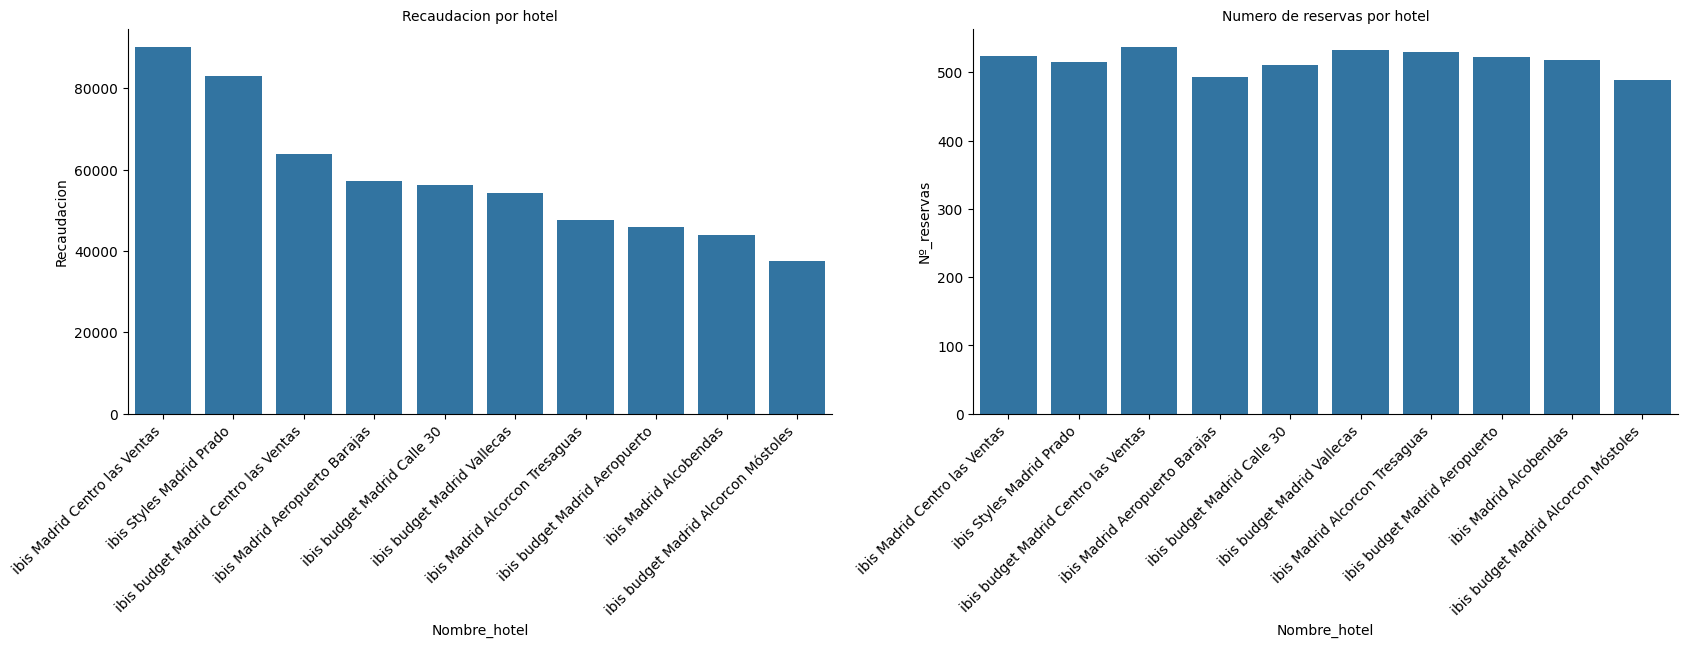

In [47]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5))

sns.barplot(x = 0, 
            y = 1,
            data = df_comp,
            ax = axes[0])

sns.barplot(x = 0, 
            y = 2,
            data = df_comp,
            ax = axes[1])

axes[0].set_title(f"Recaudacion por hotel", fontsize = 10)
axes[0].set_xlabel("Nombre_hotel", fontsize = 10)
axes[0].set_ylabel("Recaudacion", fontsize = 10)
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].set_xticklabels(labels = df_comp[0], rotation=45, ha='right')


axes[1].set_title(f"Numero de reservas por hotel", fontsize = 10)
axes[1].set_ylabel("Nº_reservas", fontsize = 10)
axes[1].set_xlabel("Nombre_hotel", fontsize = 10)
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].set_xticklabels(labels = df_comp[0], rotation=45, ha='right')

plt.show()


Realizar un análisis temporal de las reservas de la competencia no tiene sentido, ya que la fecha de reserva la pusimos nosotros cuando scrapeamos la información. Haremos un análisis.

## Conclusiones
### Big Numbers

In [56]:
from IPython.display import Markdown


tabla_bn = f"""
| Métrica            | Hoteles_Grupo | Hoteles_Competencia |
|--------------------|--------------|---------------------|
| Recaudación Total |{round(rec_total[0][0], 2)}|  {round(rec_total_c[0][0], 2)} |
| Precio Medio      |{round(p_medio[0][0], 2)}  |{round(p_medio_c[0][0], 2)} |
| Reservas Totales  |{reservas_tot[0][0]}       |{reservas_tot_c[0][0]} |
| Valoración Media  |{round(v_media[0][0], 2)}  | {round(v_media_c[0][0], 2)} |
"""

# Mostrar la tabla en Markdown
display(Markdown(tabla_bn))



| Métrica            | Hoteles_Grupo | Hoteles_Competencia |
|--------------------|--------------|---------------------|
| Recaudación Total |2703317.14|  580029.0 |
| Precio Medio      |275.06  |112.15 |
| Reservas Totales  |9828       |9828 |
| Valoración Media  |3.01  | 4.39 |


`Hoteles del grupo`

EL hotel del grupo que ha obtenido una mayor recaudación ha sido el Hotel Monte Verde, y el que menos el Hotel Palacio Imperial. EN cuanto al número de reservas el hotel con el mayor número de reservas ha sido el Hotel Sol y Luna, y el que menos ha sido el Hotel Palacio Imperial. Se recomienda revisar que pasa con el hotel Palacio Imperial.

`Hoteles de la competencia`
